In [2]:
# REF: https://machinelearningmastery.com/building-a-plain-seq2seq-model-for-language-translation/
# https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [1]:
import os
import requests
import unicodedata 
import zipfile 
import os
import tokenizers
import numpy as np
import random

In [2]:
import sys
#!{sys.executable} -m pip install tokenizers
sys.executable

'/home/aldo/hmmenv/bin/python'

In [3]:
def normalize(line):
    line = unicodedata.normalize("NFKC", line.strip().lower())
    eng, spa = line.split("\t")[:2]
    return eng.lower().strip(), spa.lower().strip()

text_pairs = []
with zipfile.ZipFile("spa-eng.zip", "r") as zip_ref:
    for k, line in enumerate(zip_ref.read("spa.txt").decode("utf-8").splitlines(),start=1):
        print(line, end="\r")
        eng, spa = normalize(line)
        text_pairs.append((eng, spa))
    print(k)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [4]:
en_tokenizer = tokenizers.Tokenizer(tokenizers.models.BPE())
es_tokenizer = tokenizers.Tokenizer(tokenizers.models.BPE())
# config tokenizer
en_tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.ByteLevel(add_prefix_space=True)
es_tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.ByteLevel(add_prefix_space=True)

# config decoder
en_tokenizer.decoder = tokenizers.decoders.ByteLevel()
es_tokenizer.decoder = tokenizers.decoders.ByteLevel()

# train BPE foen eng spa 
VOCAB_SIZE = 8000
trainer = tokenizers.trainers.BpeTrainer(vocab_size=VOCAB_SIZE,  special_tokens=["[start]", "[end]", "[pad]"],
                                        show_progress=True)
en_tokenizer.train_from_iterator([x[0] for x in text_pairs], trainer=trainer)
es_tokenizer.train_from_iterator([x[1] for x in text_pairs], trainer=trainer)

en_tokenizer.enable_padding(pad_id=en_tokenizer.token_to_id("[pad]"), pad_token="[pad]")
es_tokenizer.enable_padding(pad_id=es_tokenizer.token_to_id("[pad]"), pad_token="[pad]")
# save trained tokenizers
en_tokenizer.save("en_tokenizer.json", pretty=True)
es_tokenizer.save("es_tokenizer.json", pretty=True)


In [5]:
print("Sample Tokenization:")
en_sample, es_sample = random.choice(text_pairs)
encoded = en_tokenizer.encode(en_sample)

print(f"Original: {en_sample}")
print(f"Tokens: {encoded.tokens}")
print(f"IDs: {encoded.ids}")
print(f"Decoded: {en_tokenizer.decode(encoded.ids)}")
print()
 
encoded = es_tokenizer.encode("[start] " + es_sample + " [end]")
print(f"Original: {es_sample}")
print(f"Tokens: {encoded.tokens}")
print(f"IDs: {encoded.ids}")
print(f"Decoded: {es_tokenizer.decode(encoded.ids)}")
print()

Sample Tokenization:
Original: don't cry. everything's going to be ok.
Tokens: ['Ġdon', "'t", 'Ġcry', '.', 'Ġeverything', "'s", 'Ġgoing', 'Ġto', 'Ġbe', 'Ġok', '.']
IDs: [157, 111, 1068, 14, 583, 133, 302, 78, 131, 1460, 14]
Decoded:  don't cry. everything's going to be ok.

Original: no llores, todo va a salir bien.
Tokens: ['[start]', 'Ġno', 'Ġllores', ',', 'Ġtodo', 'Ġva', 'Ġa', 'Ġsalir', 'Ġbien', '.', 'Ġ', '[end]']
IDs: [0, 113, 6769, 12, 329, 313, 83, 980, 373, 14, 72, 1]
Decoded:  no llores, todo va a salir bien. 



In [6]:
# seq2seq architecture with LSTM

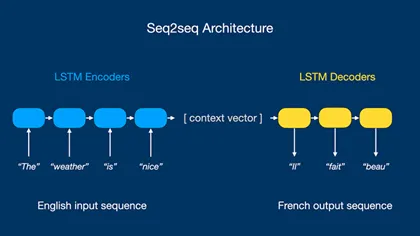

## Seq2Seq with LSTM

In [7]:
import torch
import torch.nn as nn

class EncoderLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers>1 else 0)
    
    def forward(self, input_seq):
        # input_seq 2d embbeded into 3d 
        embedded = self.embedding(input_seq)
        # outputs and states
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class DecoderLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size    = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim    = hidden_dim
        self.num_layers    = num_layers
        self.embedding     =nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers >1 else 0)
        self.out = nn.Linear(embedding_dim, vocab_size)
    
    def forward(self, input_seq, hidden, cell):
        embedded = self.embedding(input_seq)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.out(output)
        return prediction, hidden, cell



In [28]:
class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, input_seq, target_seq):
        batch_size, target_len =target_seq.shape
        device = target_seq.device
        outputs = []
        _enc_out, hidden, cell = self.encoder(input_seq)
        dec_in = target_seq[:, -1:, :]
        for 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://download.pytorch.org/whl/cu126
